# Ex3 - Raz Bareli

### Q1)

In [83]:
import pandas as pd
import numpy as np
from scipy.stats import randint
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, make_scorer
import seaborn as sns

In [84]:
df = pd.read_csv("ex3.csv")

We'll take only the features we want to work with:

In [85]:
df = df[['state','date','congressional_district','gun_type','participant_gender', 'n_killed']]

In order to work with the data, we have to fill null values, and do some data engineering as we did in previous exercises, so that's what we'll do first.
I saw in the forum that you said it's not the essence of the exercise, but I don't see any other way to handle the data without it. So I'll do some basic
operations just so I could train models on the data.

In [86]:
# fill null values with mode as in ex1:
for column in df:
    df[column] = df[column].fillna(df[column].mode()[0])

In [87]:
# modify 'participant_gender' as in ex2
df.loc[df['participant_gender'].str.contains('Female', regex=True) & df['participant_gender'].str.contains('Male', regex=True), ['participant_gender']] = "Both"
df.loc[df['participant_gender'].str.contains('Female', regex=True), ['participant_gender']] = "Female"
df.loc[df['participant_gender'].str.contains('Male', regex=True), ['participant_gender']] = "Male"


In [88]:
# modify 'gun_type' as in ex2
df['Gun']=df.gun_type.str.extract('([A-Za-z]+|[0-9][mm]+)')
def combine_guns(x):
    if x in ["Handgun","9mm","0mm", "Win","Spl", "Spr"]:
        return 'Handgun'
    if x in ["Other", "Unknown"]:
        return 'Unknown'
    else:
        return 'Rifle'
df["Gun"] = df["Gun"].apply(lambda x:combine_guns(x))
df['gun_type'] = df['Gun']
df = df.drop(columns='Gun')

In [89]:
# modify date to year/month as in ex1
def delete_day(x):
    return x[:-3]
df['date'] = df['date'].apply(delete_day)

Now we can get to the model training part:

In [90]:
# create dummy variables
# ive changed the names so it will be possible to un-dummie the database later on
df.rename(columns = {'participant_gender':'gender', 'congressional_district':'district',
                              'gun_type':'gun', 'n_killed': 'killed'}, inplace = True)
df = pd.get_dummies(df, columns=['state', 'date', 'gun', 'gender'])

In [93]:
X = df.drop(columns=['killed'])
y = df['killed']

In [95]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

I'll choose 2 models:
1. Linear Regression
2. Random Forest

Both are Regression models since we are trying to predict an integer between 0 and inf.
We could, technically,  have taken a multiclass classifier in that case, but I don't think that it suits here
since there are hierarchies between the classes. That is, 10 killed are much more than 2 killed.
So that's why I've picked regression models.

For the metric I'll choose the MSE metric.
The advantage of MSE is that it gives different weights to large errors and small errors.
That is, a larger error in our prediction (say, we predicted 100 instead of 1) will increase the MSE more that a smaller
prediction error (if we predicted 2 instead of 1).

One disadvantage of this metric is that we can't really tell how many times we were wrong. For instance,
If we predict everything wrong, say: 1 instead of 0 and 0 instead of 1, the MSE won't be large, but obviously the prediction is very bad.
In this case, the accuracy metric would have an advantage since it would have told us that we are 100% wrong.

In [22]:
# linear regression
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_y_pred = lr.predict(X_test)
lr_mse =  mean_squared_error(y_test, lr_y_pred)
print("MSE for Linear Regression = ", lr_mse)

MSE for Linear Regression =  28120899355837.75


In [23]:
# random forest
rfr = RandomForestRegressor()
rfr.fit(X_train, y_train)
rfr_y_pred = rfr.predict(X_test)
rfr_mse = mean_squared_error(y_test, rfr_y_pred)
print("MSE for Random Forest Regression = ", rfr_mse)

MSE for Random Forest Regression =  0.2866970476488128


As we can see, the errors are not too large and both models performed pretty much the same, when comparing with the MSE metric.
However, I think that since most of the n_killed data is either 0 or 1, most of the predictions are in that area as well,
And as I explained before, it's hard to tell just based of one metric if the predictions were good, since they can all be wrong
in the worst case, and still get a relatively low MSE.

### Q2)

For this question I'll continue with the Random Forest Regressor from Q1, so we can see if we can improve the model by
hyperparameter selection.

I'll use Grid Search and Random Search.

I've chosen 3 hyperparameters and 2 values for each, and cv=3 in cross validation - only because otherwise it would take too
long to run (even with these settings it can take up to 10 minutes on my PC).

Ideally, I would have chosen 4 parameters as the exersice suggests, and more values for each parameter, as well as cv=5 cross validation
which is the standard from what I understand.

I've chosen the MSE score, for the same reasons I've mentioned earlier, and so I'll be able to compare it to the results in Q1.

In [24]:
# Grid Search
gs_rfr = RandomForestRegressor()
params_grid = {
    'n_estimators': [10, 100],
    'max_depth': [20, 50],
    'min_samples_split': [5, 20],
}
n_combinations = np.array([len(l) for key, l in params_grid.items()]).prod() # to use in random grid search
gs = GridSearchCV(estimator=gs_rfr, param_grid=params_grid, verbose=3, cv=3, scoring=make_scorer(mean_squared_error, greater_is_better = False))
gs.fit(X_train, y_train)

print('Best parameters: ', gs.best_params_)
print('Best Score: ', abs(gs.best_score_))

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV 1/3] END max_depth=20, min_samples_split=5, n_estimators=10;, score=-0.269 total time=   1.1s
[CV 2/3] END max_depth=20, min_samples_split=5, n_estimators=10;, score=-0.248 total time=   1.0s
[CV 3/3] END max_depth=20, min_samples_split=5, n_estimators=10;, score=-0.258 total time=   1.0s
[CV 1/3] END max_depth=20, min_samples_split=5, n_estimators=100;, score=-0.266 total time=  12.7s
[CV 2/3] END max_depth=20, min_samples_split=5, n_estimators=100;, score=-0.245 total time=  10.2s
[CV 3/3] END max_depth=20, min_samples_split=5, n_estimators=100;, score=-0.253 total time=   9.1s
[CV 1/3] END max_depth=20, min_samples_split=20, n_estimators=10;, score=-0.263 total time=   1.1s
[CV 2/3] END max_depth=20, min_samples_split=20, n_estimators=10;, score=-0.244 total time=   1.1s
[CV 3/3] END max_depth=20, min_samples_split=20, n_estimators=10;, score=-0.250 total time=   0.9s
[CV 1/3] END max_depth=20, min_samples_split=20, n_e

In [25]:
# Random Grid Search:
rgs_rfr = RandomForestRegressor()

ranges = {
    'n_estimators': randint(10, 100),
    'max_depth': randint(20, 50),
    'min_samples_split': randint(5, 20)
}
rgs = RandomizedSearchCV(estimator=rgs_rfr, param_distributions=ranges, verbose=3, cv=3,  scoring=make_scorer(mean_squared_error, greater_is_better = False), n_iter=n_combinations)
rgs.fit(X_train, y_train)

print('Best parameters: ', rgs.best_params_)
print('Best Score: ', abs(rgs.best_score_))

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV 1/3] END max_depth=39, min_samples_split=17, n_estimators=68;, score=-0.272 total time=  12.1s
[CV 2/3] END max_depth=39, min_samples_split=17, n_estimators=68;, score=-0.252 total time=  12.8s
[CV 3/3] END max_depth=39, min_samples_split=17, n_estimators=68;, score=-0.260 total time=  12.8s
[CV 1/3] END max_depth=38, min_samples_split=13, n_estimators=83;, score=-0.275 total time=  22.4s
[CV 2/3] END max_depth=38, min_samples_split=13, n_estimators=83;, score=-0.253 total time=  22.8s
[CV 3/3] END max_depth=38, min_samples_split=13, n_estimators=83;, score=-0.263 total time=  21.0s
[CV 1/3] END max_depth=47, min_samples_split=18, n_estimators=92;, score=-0.275 total time=  17.6s
[CV 2/3] END max_depth=47, min_samples_split=18, n_estimators=92;, score=-0.253 total time=  26.1s
[CV 3/3] END max_depth=47, min_samples_split=18, n_estimators=92;, score=-0.263 total time=  13.8s
[CV 1/3] END max_depth=26, min_samples_split=16, 

Well, we can see that the grid search found hyperparameters that gave a bit better results on the train set, than the random grid.
As we discussed in class - since this is random, the opposite could happen if we'll run it again,
since we are not limited to the values we gave the model in the first place,
and of course we need a bit of luck as well since choosing the parameter is randomly made.

Now just for fun lets compare the new fitted models to the one from question 1:


In [26]:
print("question 1 forest error: ", rfr_mse)
print("grid search forest error: ", mean_squared_error(y_test, gs.predict(X_test)))
print("random grid search forest error: ", mean_squared_error(y_test, rgs.predict(X_test)))

question 1 forest error:  0.2866970476488128
grid search forest error:  0.23834391250459477
random grid search forest error:  0.2406516265018417


And we can see that the hyperparamater optimization led to a better results!

### Q3.a)

We'll use the Random Forest Regressor from previous question, with the hyperparameters we've found to perform best.
This time well train it on all the original dataset (without cross validation).

In [ ]:
rfr_q3 = gs.best_estimator_
rfr_q3.fit(X_train, y_train)

In [39]:
y_pred = rfr_q3.predict(X_test)
print("MSE = ", mean_squared_error(y_test, y_pred))

MSE =  0.23926398474969832


Now we'll show the importance, as we learned in class:

In [ ]:
feature_importances = sorted(list(zip(X_train.columns, rfr_q3.feature_importances_)), key=lambda x: -x[1])

Now, in order to show the data in a bar plot, we need to combine all the "new features" from the one-hot-encoding process
to their original features. That's what I'll do next:

In [62]:
feature_importances_dict = {'state' : 0, 'gender':0, 'district':0, 'date':0, 'gun_type':0}
for i in feature_importances:
    curr_feature = None
    if i[0].startswith('state'):
        curr_feature = 'state'
    elif i[0].startswith('gender'):
        curr_feature = 'gender'
    elif i[0].startswith('district'):
        curr_feature = 'district'
    elif i[0].startswith('date'):
        curr_feature = 'date'
    elif i[0].startswith('gun'):
        curr_feature = 'gun_type'
    feature_importances_dict[curr_feature] += i[1]
feature_importances_dict

{'state': 0.1956680960995825,
 'gender': 0.17514167333865377,
 'district': 0.10865080105397927,
 'date': 0.47705366616013595,
 'gun_type': 0.04348576334764857}

In [63]:
features = list(feature_importances_dict.keys())
importances = list(feature_importances_dict.values())

<AxesSubplot:>

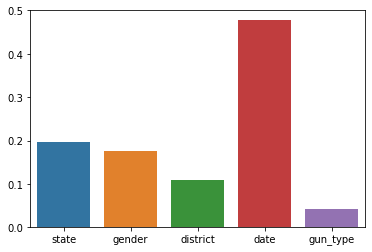

In [64]:
sns.barplot(x=features, y=importances)

### 3.b)

Model without the most important feature (date):
First we'll have to reverse the one hot encoding process, to eliminate the date feature (function taken from stackoverflow):

In [101]:
def undummify(df, prefix_sep="_"):
    cols2collapse = {
        item.split(prefix_sep)[0]: (prefix_sep in item) for item in df.columns
    }
    series_list = []
    for col, needs_to_collapse in cols2collapse.items():
        if needs_to_collapse:
            undummified = (
                df.filter(like=col)
                .idxmax(axis=1)
                .apply(lambda x: x.split(prefix_sep, maxsplit=1)[1])
                .rename(col)
            )
            series_list.append(undummified)
        else:
            series_list.append(df[col])
    undummified_df = pd.concat(series_list, axis=1)
    return undummified_df

In [ ]:
# reverse and drop date
df_1 = undummify(df)
df_1 = df_1.drop(columns='date')

In [102]:
# now we'll do one hot encoding again:
df_1 = pd.get_dummies(df_1, columns=['state', 'gun', 'gender'])

In [103]:
X =  df_1.drop(columns='killed')
y = df_1['killed']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

3899     0
15942    0
17712    0
23463    0
17354    0
        ..
1859     0
22479    1
16156    1
20997    0
2236     0
Name: killed, Length: 9900, dtype: int64